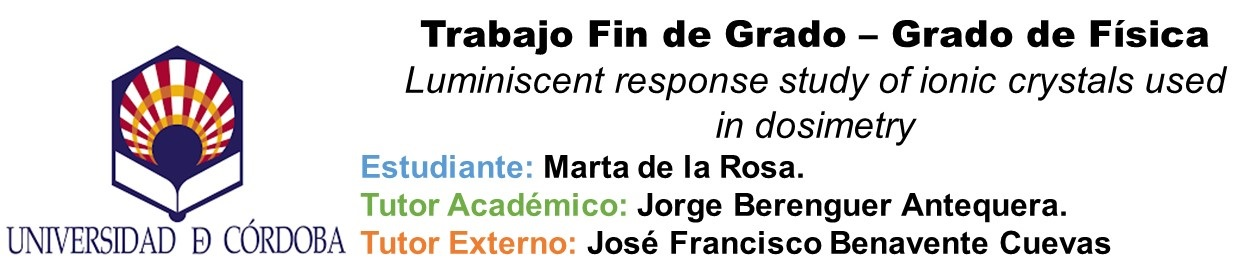

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from types import SimpleNamespace

# 1. Importing data

In [2]:
## STRUCTURAL PARAMETERS

PathStructural = 'ExperimentalData/ParametrosEstructurales.xlsx'
StructuralData = pd.read_excel(PathStructural, sheet_name='Hoja1', header=0, usecols=None, nrows=None)

# Total density of available positions for traps and Radiative/Non radiative recombination centers (cm-3)
N_I, N_II, N_III, N_IV, N_V, N_s = StructuralData.iloc[[0],[0]].values[0][0],StructuralData.iloc[[1],[0]].values[0][0],StructuralData.iloc[[2],[0]].values[0][0],StructuralData.iloc[[3],[0]].values[0][0],StructuralData.iloc[[4],[0]].values[0][0],StructuralData.iloc[[5],[0]].values[0][0]                    
M_R, M_NR=StructuralData.iloc[[0],[1]].values[0][0],StructuralData.iloc[[0],[2]].values[0][0]


# Electron trapping probability factor for traps and Radiative/Non radiative recombination centers (cm3/s)
A_I, A_II, A_III, A_IV, A_V, A_s = StructuralData.iloc[[0],[3]].values[0][0],StructuralData.iloc[[1],[3]].values[0][0],StructuralData.iloc[[2],[3]].values[0][0],StructuralData.iloc[[3],[3]].values[0][0],StructuralData.iloc[[4],[3]].values[0][0],StructuralData.iloc[[5],[3]].values[0][0]

# Hole trapping probability factor for Radiative/Non Radiative recomb. centers (cm3/s)
A_NR, A_R = StructuralData.iloc[[0],[6]].values[0][0], StructuralData.iloc[[0],[7]].values[0][0]

# Electron-hole trapping probability factor for radiative/non radiative recomb. centers (cm3/s)
A_mn_NR,A_mn_R=StructuralData.iloc[[0],[4]].values[0][0],StructuralData.iloc[[0],[5]].values[0][0]



## CINETIC PARAMETERS

PathCinetics = 'ExperimentalData/ParametrosCineticos.xlsx'
CineticsData = pd.read_excel(PathCinetics, sheet_name='Hoja1', header=0, usecols=None, nrows=None)

# Threshold energy for traps and Radiative/Non radiative recombination centers (eV)
E_I,E_II,E_III,E_IV,E_V,E_s=CineticsData.iloc[[0],[0]].values[0][0],CineticsData.iloc[[1],[0]].values[0][0],CineticsData.iloc[[2],[0]].values[0][0],CineticsData.iloc[[3],[0]].values[0][0],CineticsData.iloc[[4],[0]].values[0][0],CineticsData.iloc[[5],[0]].values[0][0]                            
E_R_h, E_NR_h = CineticsData.iloc[[0], [2]].values[0][0], CineticsData.iloc[[0], [4]].values[0][0]           


# Frequency factor for trap i (s-1)
S_I,S_II,S_III,S_IV,S_V,S_s=CineticsData.iloc[[0],[1]].values[0][0],CineticsData.iloc[[1],[1]].values[0][0],CineticsData.iloc[[2],[1]].values[0][0],CineticsData.iloc[[3],[1]].values[0][0],CineticsData.iloc[[4],[1]].values[0][0],CineticsData.iloc[[5],[1]].values[0][0]
S_R_h, S_NR_h = CineticsData.iloc[[0], [3]].values[0][0], CineticsData.iloc[[0], [5]].values[0][0]


# 2. Differential Equations System

In [3]:
import sys
sys.path.append('Functions')

from diff_eqs_freqfactor import diff_eqs_freqfactor
from diff_eqs_growth import diff_eqs_growth
from diff_eqs_notemp import diff_eqs_notemp

# For the global variables, we need to define a SimpleNamespace
value = SimpleNamespace(
    kB=0,
    G=0, hr=0, 
    N_I=N_I, N_II=N_II, N_III=N_III, N_IV=N_IV, N_V=N_V, N_s=N_s,
    M_R=M_R, M_NR=M_NR,
    A_I=A_I, A_II=A_II, A_III=A_III, A_IV=A_IV, A_V=A_V, A_s=A_s, A_NR=A_NR, A_R=A_R,
    E_I=E_I, E_II=E_II, E_III=E_III, E_IV=E_IV, E_V=E_V, E_s=E_s, E_R_h=E_R_h, E_NR_h=E_NR_h,
    S_I=S_I, S_II=S_II, S_III=S_III, S_IV=S_IV, S_V=S_V, S_s=S_s, S_R_h=S_R_h, S_NR_h=S_NR_h,
    A_mn_NR=A_mn_NR, A_mn_R=A_mn_R
)

# Define the columns for the dataframe
column_names = [
    'n_I', 'n_II', 'n_III', 'n_IV', 'n_V',
    'n_s', 'm_R', 'm_NR', 'n_c', 'n_v',
    'dm_R', 'dm_NR'
]


## 2.1 Irradiation

There's no heating (`hr = 0` ºC/s). The temperature is set at 25ºC, and the electron-hole pair generation is set at `G = 1000` cm $^{-3}$ s $^{-1}$.

/var/folders/_c/s9xtx7kn61l5wvpw4pyjsc8c0000gn/T/ipykernel_78039/3817646724.py:48: RuntimeWarning: invalid value encountered in divide
  plt.plot(t, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR))


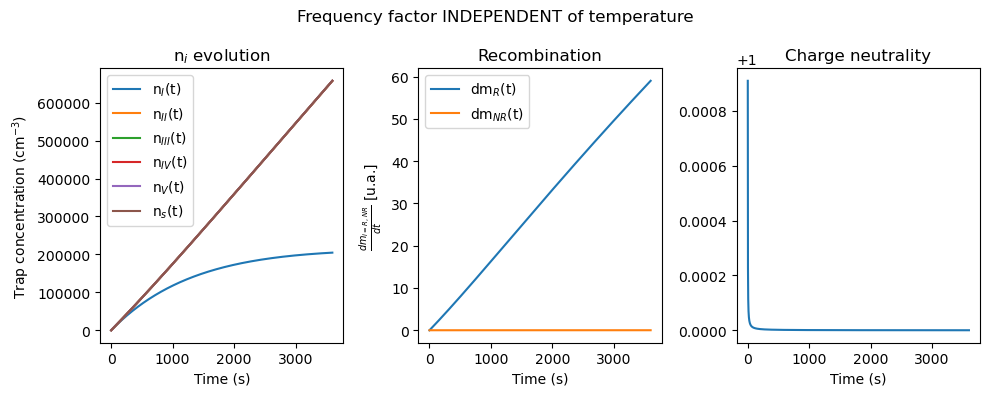

In [7]:

# Parameters for IRRADIATION
value.kB = 8.617e-5        # Boltzmann constant (eV/K)
value.T_C = 25             # Temperature (ºC)
value.hr = 0               # Heating rate (ºC/s)
value.G = 1000             # Electron-hole pair generation (cm-3 s-1)

# Time vector (s)
npoints = 3600
t = np.linspace(0, npoints-1, npoints)

# Initial conditions vector
n_I_0, n_II_0, n_III_0, n_IV_0, n_V_0, n_s_0, m_NR_0, m_R_0, n_c_0, n_v_0 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
y0 = [n_I_0, n_II_0, n_III_0, n_IV_0, n_V_0, n_s_0, m_NR_0, m_R_0, n_c_0, n_v_0]

# Solving the differential equations system
irradiation = odeint(diff_eqs_freqfactor, y0, t, args=(value,))
n_I, n_II, n_III ,n_IV ,n_V ,n_s ,m_R ,m_NR ,n_c , n_v = irradiation.T

# Intensity for the glow curve (eq 3.7)
dm_R = m_R * A_mn_R * n_c
dm_NR = m_NR * A_mn_NR * n_c
irradiation = np.column_stack((irradiation, dm_R, dm_NR))

# Plotting
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.plot(t, n_I, label='n$_{I}$(t)')
plt.plot(t, n_II, label='n$_{II}$(t)')
plt.plot(t, n_III, label='n$_{III}$(t)')
plt.plot(t, n_IV, label='n$_{IV}$(t)')
plt.plot(t, n_V, label='n$_{V}$(t)')
plt.plot(t, n_s, label='n$_{s}$(t)')
plt.xlabel('Time (s)')
plt.ylabel('Trap concentration (cm$^{-3}$)')
plt.title('n$_{i}$ evolution')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 2)
plt.plot(t, dm_R, label='dm$_{R}$(t)')
plt.plot(t, dm_NR, label='dm$_{NR}$(t)')
plt.xlabel('Time (s)')
plt.ylabel(r'$\frac{dm_{i=R,NR}}{dt}$ [u.a.]')
plt.title('Recombination')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 3)
plt.plot(t, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR))
plt.xlabel('Time (s)')
plt.title('Charge neutrality')

plt.suptitle('Frequency factor INDEPENDENT of temperature')
plt.tight_layout()
plt.show()

# Saving on DataFrame
dt1 = pd.DataFrame(irradiation, columns=column_names)
dt1['t'] = t
dt1['Stage'] = 'Irradiation'


## 2.2 Relaxation

There's no heating (`h=0`) and there's no generation of electron-hole pairs (`hr=0`). The temperature is set at 25ºC

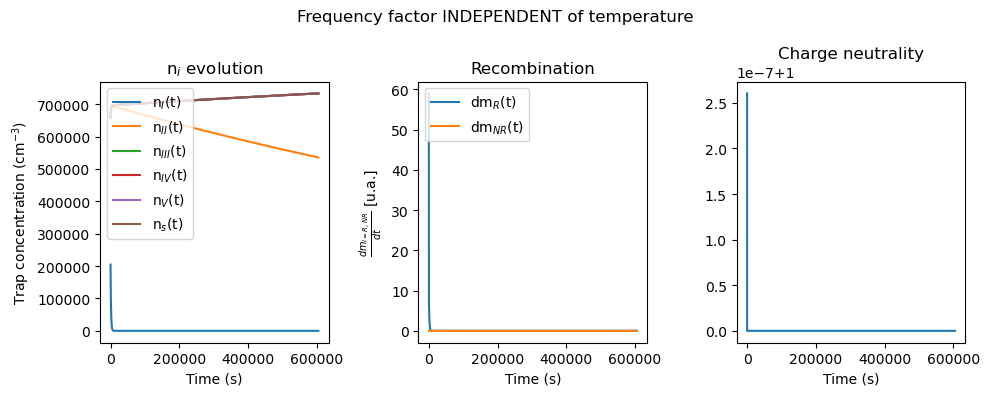

In [5]:

# Parameters for RELAXATION
value.T_C = 25             # Temperature (ºC)
value.hr = 0               # Heating rate (ºC/s)
value.G = 0                # Electron-hole pair generation (cm-3 s-1)

# Time vector (s)
npoints = 3600 * 24 * 7
t = np.linspace(0, npoints-1, npoints)

# Initial conditions vector
n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0,m_NR_0,m_R_0,n_c_0,n_v_0=n_I[-1],n_II[-1],n_III[-1],n_IV[-1],n_V[-1],n_s[-1],m_R[-1],m_NR[-1],n_c[-1], n_v[-1]
y0 = [n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0,m_NR_0,m_R_0,n_c_0,n_v_0]

# Solving the differential equations system
relaxation = odeint(diff_eqs_freqfactor, y0, t, args=(value,))
n_I, n_II, n_III ,n_IV ,n_V ,n_s ,m_R ,m_NR ,n_c , n_v = relaxation.T

# Intensity for the glow curve (eq 3.7)
dm_R = m_R * A_mn_R * n_c
dm_NR = m_NR * A_mn_NR * n_c
relaxation = np.column_stack((relaxation, dm_R, dm_NR))

# Plotting
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.plot(t, n_I, label='n$_{I}$(t)')
plt.plot(t, n_II, label='n$_{II}$(t)')
plt.plot(t, n_III, label='n$_{III}$(t)')
plt.plot(t, n_IV, label='n$_{IV}$(t)')
plt.plot(t, n_V, label='n$_{V}$(t)')
plt.plot(t, n_s, label='n$_{s}$(t)')
plt.xlabel('Time (s)')
plt.ylabel('Trap concentration (cm$^{-3}$)')
plt.title('n$_{i}$ evolution')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 2)
plt.plot(t, dm_R, label='dm$_{R}$(t)')
plt.plot(t, dm_NR, label='dm$_{NR}$(t)')
plt.xlabel('Time (s)')
plt.ylabel(r'$\frac{dm_{i=R,NR}}{dt}$ [u.a.]')
plt.title('Recombination')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 3)
plt.plot(t, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR))
plt.xlabel('Time (s)')
plt.title('Charge neutrality')

plt.suptitle('Frequency factor INDEPENDENT of temperature')
plt.tight_layout()
plt.show()

# Saving the DataFrame
dt2 = pd.DataFrame(relaxation, columns=column_names)
dt2['t'] = t
dt2['Stage'] = 'Relaxation'

## 2.3 Heating

Now the heating rate goes at `hr = 1.0` ºC/s, and the initial temperature is set at 0ºC. 

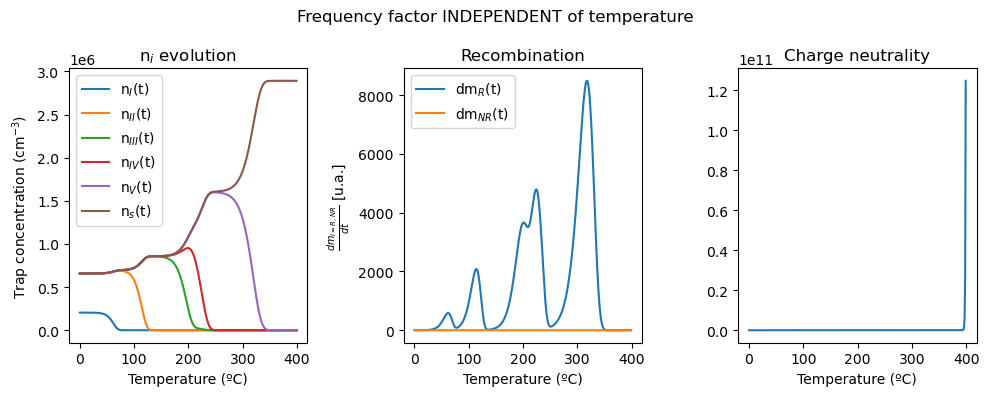

In [6]:
# Parameters for HEATING
value.T_C = 0             # Temperature (ºC)
value.hr = 1.0             # Heating rate (ºC/s)
value.G = 0                # Electron-hole pair generation (cm-3 s-1)

# Time vector (s)
npoints = 400
t = np.linspace(0, npoints-1, npoints)

# Initial conditions vector
n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0,m_NR_0,m_R_0,n_c_0,n_v_0=n_I[1],n_II[1],n_III[1],n_IV[1],n_V[1],n_s[1],m_R[1],m_NR[1],n_c[1], n_v[1]
y0 = [n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0,m_NR_0,m_R_0,n_c_0,n_v_0]

# Solving the differential equations system
heating = odeint(diff_eqs_freqfactor, y0, t, args=(value,))
n_I, n_II, n_III ,n_IV ,n_V ,n_s ,m_R ,m_NR ,n_c , n_v = heating.T

# Intensity for the glow curve (eq 3.7)
dm_R = m_R * A_mn_R * n_c
dm_NR = m_NR * A_mn_NR * n_c
heating = np.column_stack((heating, dm_R, dm_NR))

# Plotting
temp_plot = value.T_C + value.hr * t
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.plot(temp_plot, n_I, label='n$_{I}$(t)')
plt.plot(temp_plot, n_II, label='n$_{II}$(t)')
plt.plot(temp_plot, n_III, label='n$_{III}$(t)')
plt.plot(temp_plot, n_IV, label='n$_{IV}$(t)')
plt.plot(temp_plot, n_V, label='n$_{V}$(t)')
plt.plot(temp_plot, n_s, label='n$_{s}$(t)')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Trap concentration (cm$^{-3}$)')
plt.title('n$_{i}$ evolution')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 2)
plt.plot(temp_plot, dm_R, label='dm$_{R}$(t)')
plt.plot(temp_plot, dm_NR, label='dm$_{NR}$(t)')
plt.xlabel('Temperature (ºC)')
plt.ylabel(r'$\frac{dm_{i=R,NR}}{dt}$ [u.a.]')
plt.title('Recombination')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 3)
plt.plot(temp_plot, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR))
plt.xlabel('Temperature (ºC)')
plt.title('Charge neutrality')

plt.suptitle('Frequency factor INDEPENDENT of temperature')
plt.tight_layout()
plt.show()

# Saving the DataFrame 
dt3 = pd.DataFrame(heating, columns=column_names)
dt3['t'] = t
dt3['Stage'] = 'Heating'

In [ ]:
# Exporting the DataFrame
DataFrame = pd.concat([dt1, dt2, dt3], ignore_index=True)
#DataFrame.to_csv('Results/SimulationResults.csv', index=False)
#PROBLEM: the dataframe cannot be saved to git due to the size of the file